In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, Reshape, BatchNormalization
from keras.losses import BinaryCrossentropy
import time

c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
image_directory = "C:\\Users\\allan\\Downloads\\Anime faces GAN\\images"
image_dimension = 64
noise_dimensions = 64

In [3]:
list_image_names = os.listdir(image_directory)
list_image_paths = [os.path.join(image_directory, name) for name in list_image_names]

In [4]:
min_dim = 100
for path in list_image_paths:
    file = tf.io.read_file(path)
    image = tf.image.decode_jpeg(file)
    #Check if there are any greyscale images
    if image.shape[2] < 3:
        print("Greyscale detected")
        pass
    #Get if any images are not square
    if not image.shape[0] == image.shape[1]:
        print("Not square image. Shape is {0}".format(image.shape))
        continue
    if image.shape[0] < min_dim:
        min_dim = image.shape[0]
    pass
print("Minimum Dimensions is {0}".format(min_dim))

Not square image. Shape is (123, 124, 3)
Not square image. Shape is (130, 131, 3)
Not square image. Shape is (185, 186, 3)
Not square image. Shape is (112, 113, 3)
Not square image. Shape is (87, 88, 3)
Not square image. Shape is (63, 64, 3)
Not square image. Shape is (112, 113, 3)
Not square image. Shape is (96, 97, 3)
Not square image. Shape is (130, 131, 3)
Not square image. Shape is (123, 124, 3)
Not square image. Shape is (123, 124, 3)
Not square image. Shape is (126, 127, 3)
Not square image. Shape is (132, 133, 3)
Not square image. Shape is (101, 102, 3)
Not square image. Shape is (84, 85, 3)
Not square image. Shape is (51, 52, 3)
Not square image. Shape is (92, 93, 3)
Minimum Dimensions is 25


In [5]:
#Acceptable resolution ratios, so we can just use all the images in the dataset

In [6]:
#Set up the dataset
def create_dataset(directory_path, image_dimension):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory_path,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(image_dimension, image_dimension),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    dataset = dataset.map(map_dataset)
    return dataset

def map_dataset(datapoint):
    return (datapoint-127.5)/127.5

def plot_image(image_tensor):
    plt.imshow(image_tensor*0.5 + 0.5)
    plt.show()

In [7]:
dataset = create_dataset(image_directory, image_dimension)

Found 63565 files belonging to 1 classes.


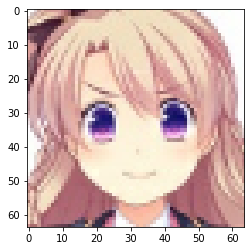

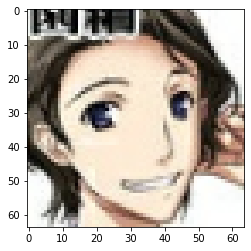

In [8]:
for batch in dataset.take(2):
    single_image = batch[0]
    plot_image(single_image)

In [9]:
#Auto encoder for a generator
first_layer_filters = 64
kernel_size = 4
autoencoder_generator = tf.keras.models.Sequential([

    #Encoding layers
    Input(shape=[noise_dimensions]),
    Dense(units = image_dimension*image_dimension*3),
    Reshape(target_shape=(image_dimension, image_dimension, 3)),
    Conv2D(filters = first_layer_filters, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Bottleneck layer
    Conv2D(filters = first_layer_filters*8, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Decoding layers
    Conv2DTranspose(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = 3, kernel_size=kernel_size, strides = 2, padding = 'same', activation='tanh', use_bias=False),
])

In [10]:
#Build a normal encoder with a single output neuron as a discriminator
discriminator_filters = 64
kernel_size = 4
discriminator = tf.keras.models.Sequential([
    Input(shape = (image_dimension, image_dimension, 3)),
    Conv2D(filters = discriminator_filters, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*2, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*4, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*8, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(units = 1, activation='sigmoid')
])

In [11]:
#Define separate optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [12]:
#Define a loss function. It just calculates loss, so one is enough for both models
loss_function = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
#Define some metrics to evaluate accuracy
discriminator_fake_accuracy = tf.keras.metrics.BinaryAccuracy()
discriminator_real_accuracy = tf.keras.metrics.BinaryAccuracy()

In [13]:
def save_the_model_checkpoint(model, epoch_number):
    #Save the whole GAN
    model.save("Saved_models/Trained_Epochs{}".format(epoch_number))
    pass

In [14]:
def train_the_model(dataset, epochs, noise_dimensions, GAN):
    input, generator, discriminator = GAN.layers
    for epoch in range(epochs):
        discriminator_losses = []
        generator_losses = []
        fake_accuracy = None
        real_accuracy = None
        start_time = time.time()
        for batch in dataset:
            #Get the batch size
            batch_size = batch.shape[0]

            #PHASE 1 TRAIN THE DISCRIMINATOR
            with tf.GradientTape() as discriminator_tape:
                #Create noise which will be the input to the generator
                noise = tf.random.normal(shape=[batch_size, noise_dimensions])
                #Pass the noise into the generator to get fake images
                fake_images = generator(noise)
                #Pass the fake images into the discriminator to get fake output (0s)
                fake_output = discriminator(fake_images)
                #Pass the real images from the batch into the discriminator to get real output (1s)
                real_output = discriminator(batch)
                #Create a tensor of 0s as labels for the fake output
                fake_labels = tf.constant(0, shape = (batch_size, 1), dtype=tf.int32)
                #Create a tensor of 1s as labels for the real output
                real_labels = tf.constant(1, shape = (batch_size, 1), dtype=tf.int32)
                #Calculate loss for fake outputs
                fake_loss = loss_function(y_pred=fake_output, y_true=fake_labels)
               
                #Calculate loss for real outputs
                real_loss = loss_function(y_pred=real_output, y_true=real_labels)
                
                #Concatenate the fake and real losses
                total_loss = tf.concat([fake_loss, real_loss], axis = 0)
                #Calculate the gradient of the total loss with respect to the the model trainable variables
                gradients = discriminator_tape.gradient(total_loss, discriminator.trainable_variables)
                #Apply the gradients to the model's trainable weights
                discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
                pass

            #Evaluation only
            discriminator_losses.append(tf.reduce_mean(total_loss))
            #Calculate metric for fake images
            discriminator_fake_accuracy.update_state(y_true = fake_labels, y_pred = fake_output)
            fake_accuracy = discriminator_fake_accuracy.result()
            #Calculate metric for real images
            discriminator_real_accuracy.update_state(y_true = real_labels, y_pred = real_output)
            real_accuracy = discriminator_real_accuracy.result()
            discriminator_fake_accuracy.reset_state()
            discriminator_real_accuracy.reset_state()

            #PHASE 2 TRAIN THE GENERATOR
            with tf.GradientTape() as generator_tape:
                #Create noise with the same dimensions as earlier
                noise = tf.random.normal(shape=[batch_size, noise_dimensions])
                #Pass the noise through the generator to create fake images
                generated_images = generator(noise)

                #Create labels for these images (1s). We want to trick the discriminator
                y_true_generator = tf.constant(1, shape = (batch_size, 1), dtype=tf.int32)
                #Pass the fake images through the discriminator to get the actual outputs
                y_pred_generator = discriminator(generated_images)
                #Calculate the loss using the loss function, between the created labels and the actual outputs
                generator_loss = loss_function(y_true=y_true_generator, y_pred=y_pred_generator)
                #Calculate the gradient of the loss with respect to the generator's trainable variables. (RECHECK THIS ONE. SHOULD I CALCULATE THE GRADIENT FOR THE WHOLE NETWORK BY FREEZING THE DISCRIMINATOR)
                gradients = generator_tape.gradient(generator_loss, GAN.trainable_variables)
                #Using the optimizer, apply the gradients to the generator's trainable weights
                discriminator.trainable = False
                generator_optimizer.apply_gradients(zip(gradients, GAN.trainable_variables))
                discriminator.trainable = True

                #Evaluation only
                generator_losses.append(tf.reduce_mean(generator_loss))
                pass
            pass
        #Calculate the time for each epoch
        end_time = time.time()
        print("Time for epoch {0} is {1} || Total Discriminator Loss = {2} || Generator Loss (Trick) = {3} || Fake accuracy = {4} || Real accuracy = {5}".format(epoch+1, (end_time-start_time), tf.reduce_mean(discriminator_losses), tf.reduce_mean(generator_losses), fake_accuracy, real_accuracy))
        #Create noise
        noise = tf.random.normal(shape = [1, noise_dimensions])
        test_image = generator(noise)[0]
        plot_image(test_image)
        pass
    save_the_model_checkpoint(GAN, epochs)
    pass

In [15]:
gen_inputs = autoencoder_generator.input
gen_output = autoencoder_generator(gen_inputs)
disc_input = gen_output
disc_output = discriminator(disc_input)
GAN = tf.keras.Model(inputs = gen_inputs, outputs = disc_output)
GAN.summary()
print(GAN.layers)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         6315520   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2767617   
                                                                 
Total params: 9,083,137
Trainable params: 9,078,401
Non-trainable params: 4,736
_________________________________________________________________
[<keras.engine.input_layer.InputLayer object at 0x00000237CCF71000>, <keras.engine.sequential.Sequential object at 0x00000237D0BB4310>, <keras.engine.sequential.Sequential object at 0x00000237D0C1B700>]


c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Time for epoch 1 is 273.2215223312378 || Total Discriminator Loss = 0.667704164981842 || Generator Loss (Trick) = 0.947719395160675 || Fake accuracy = 0.1538461595773697 || Real accuracy = 1.0


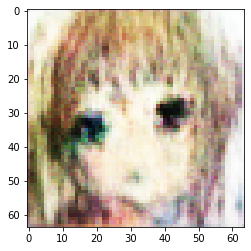

Time for epoch 2 is 273.27061200141907 || Total Discriminator Loss = 0.6292836666107178 || Generator Loss (Trick) = 1.0245319604873657 || Fake accuracy = 0.5384615659713745 || Real accuracy = 0.3076923191547394


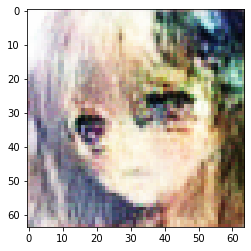

Time for epoch 3 is 265.1183834075928 || Total Discriminator Loss = 0.5906816720962524 || Generator Loss (Trick) = 1.2364025115966797 || Fake accuracy = 0.6153846383094788 || Real accuracy = 0.692307710647583


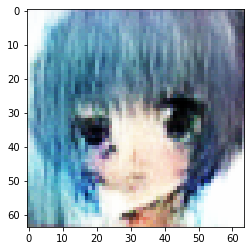

Time for epoch 4 is 267.46573305130005 || Total Discriminator Loss = 0.5666010975837708 || Generator Loss (Trick) = 1.3777012825012207 || Fake accuracy = 0.7692307829856873 || Real accuracy = 0.6153846383094788


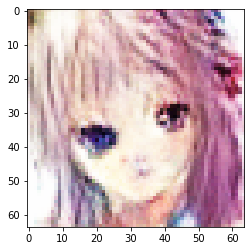

Time for epoch 5 is 262.90208768844604 || Total Discriminator Loss = 0.5238543748855591 || Generator Loss (Trick) = 1.5952056646347046 || Fake accuracy = 1.0 || Real accuracy = 0.6153846383094788


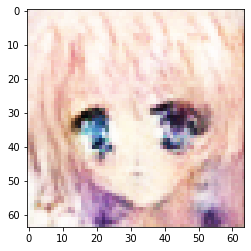

Time for epoch 6 is 262.5486304759979 || Total Discriminator Loss = 0.4065167307853699 || Generator Loss (Trick) = 2.299743413925171 || Fake accuracy = 0.9230769276618958 || Real accuracy = 0.692307710647583


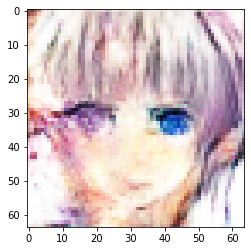

Time for epoch 7 is 263.0030429363251 || Total Discriminator Loss = 0.42671868205070496 || Generator Loss (Trick) = 2.241600275039673 || Fake accuracy = 0.7692307829856873 || Real accuracy = 1.0


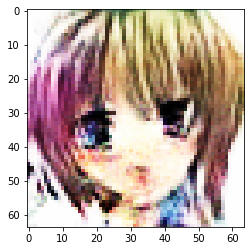

Time for epoch 8 is 262.5743863582611 || Total Discriminator Loss = 0.47465839982032776 || Generator Loss (Trick) = 2.083353042602539 || Fake accuracy = 0.692307710647583 || Real accuracy = 0.7692307829856873


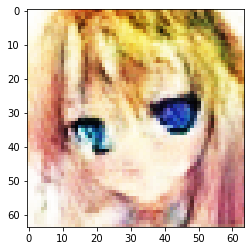

Time for epoch 9 is 262.587730884552 || Total Discriminator Loss = 0.48878979682922363 || Generator Loss (Trick) = 2.1133716106414795 || Fake accuracy = 1.0 || Real accuracy = 0.6153846383094788


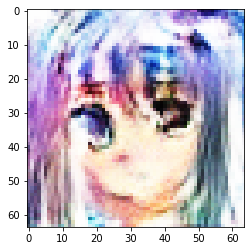

Time for epoch 10 is 263.37729692459106 || Total Discriminator Loss = 0.4906724691390991 || Generator Loss (Trick) = 2.1069209575653076 || Fake accuracy = 1.0 || Real accuracy = 0.692307710647583


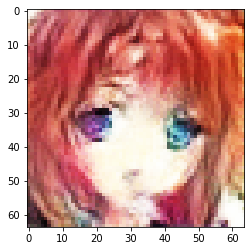

Time for epoch 11 is 262.7442991733551 || Total Discriminator Loss = 0.4945119023323059 || Generator Loss (Trick) = 2.1250534057617188 || Fake accuracy = 1.0 || Real accuracy = 0.3076923191547394


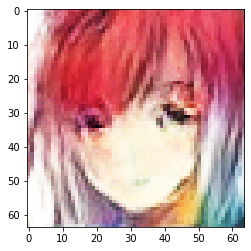

Time for epoch 12 is 262.8586699962616 || Total Discriminator Loss = 0.49266499280929565 || Generator Loss (Trick) = 2.207021951675415 || Fake accuracy = 1.0 || Real accuracy = 0.4615384638309479


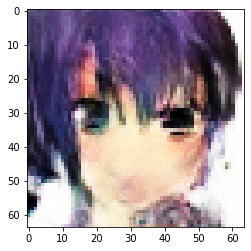

Time for epoch 13 is 263.0883185863495 || Total Discriminator Loss = 0.5019298195838928 || Generator Loss (Trick) = 2.1804583072662354 || Fake accuracy = 1.0 || Real accuracy = 0.7692307829856873


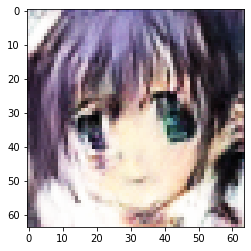

Time for epoch 14 is 263.5532627105713 || Total Discriminator Loss = 0.5033857226371765 || Generator Loss (Trick) = 2.2135446071624756 || Fake accuracy = 0.5384615659713745 || Real accuracy = 0.9230769276618958


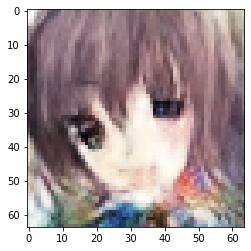

Time for epoch 15 is 263.841744184494 || Total Discriminator Loss = 0.5183319449424744 || Generator Loss (Trick) = 2.132201671600342 || Fake accuracy = 0.23076923191547394 || Real accuracy = 1.0


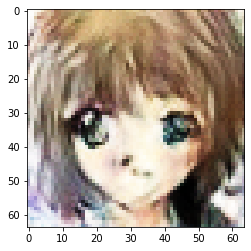

Time for epoch 16 is 265.0508089065552 || Total Discriminator Loss = 0.4972856342792511 || Generator Loss (Trick) = 2.226083517074585 || Fake accuracy = 0.0 || Real accuracy = 1.0


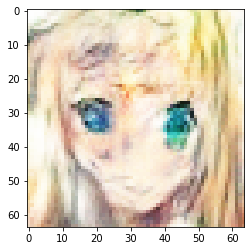

Time for epoch 17 is 268.56263303756714 || Total Discriminator Loss = 0.5087334513664246 || Generator Loss (Trick) = 2.259032964706421 || Fake accuracy = 0.692307710647583 || Real accuracy = 0.9230769276618958


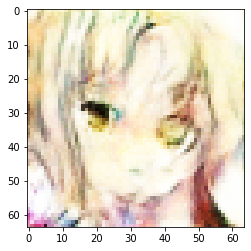

Time for epoch 18 is 265.06282591819763 || Total Discriminator Loss = 0.5003941059112549 || Generator Loss (Trick) = 2.321428060531616 || Fake accuracy = 1.0 || Real accuracy = 0.692307710647583


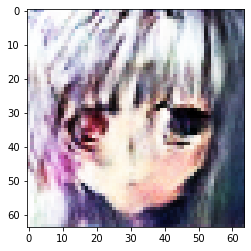

Time for epoch 19 is 265.1394612789154 || Total Discriminator Loss = 0.4873507022857666 || Generator Loss (Trick) = 2.42008638381958 || Fake accuracy = 0.692307710647583 || Real accuracy = 0.692307710647583


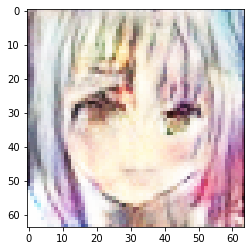

Time for epoch 20 is 267.3171033859253 || Total Discriminator Loss = 0.4807228446006775 || Generator Loss (Trick) = 2.4930288791656494 || Fake accuracy = 0.8461538553237915 || Real accuracy = 0.9230769276618958


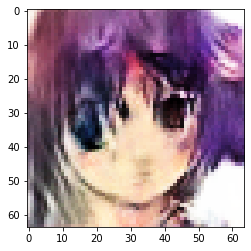

INFO:tensorflow:Assets written to: Saved_models/Trained_Epochs20\assets


INFO:tensorflow:Assets written to: Saved_models/Trained_Epochs20\assets


In [16]:
train_the_model(dataset, 20, noise_dimensions, GAN)